In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [148]:
def generator(N):
    np.random.seed(42)
    N = N
    class_1 = np.random.multivariate_normal(mean=[2.5, 2], cov=[[-0.7, 1], [1, -0.7]], size=int(N*0.4))
    class_2 = np.random.multivariate_normal(mean=[3.9, 2.2], cov=[[1, 0.7], [0.7, 1]], size=int(N*0.35))
    class_3 = np.random.multivariate_normal(mean=[0.5, 4], cov=[[0.2, 0], [0, 0.2]], size=int(N*0.25))
    
    return np.vstack([class_1, class_2, class_3]), np.hstack([np.zeros(int(N*0.4)), np.ones(int(N*0.35)), np.full(int(N*0.25), 2)])

X, y = generator(1000)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Target'] = y

df.head(3)

,Feature 1,Feature 2,Target
0,2.904398,1.488503,0.0
1,3.687006,1.992728,0.0
2,2.193440,2.125198,0.0


In [149]:
df.describe()

,Feature 1,Feature 2,Target
count,1000.000000,1000.000000,1000.000000
mean,2.422782,2.558562,0.850000
std,1.508774,1.222070,0.792545
min,-0.885044,-0.857198,0.000000
25%,1.023004,1.633721,0.000000
50%,2.524125,2.493342,1.000000
75%,3.576468,3.624718,1.250000
max,6.086597,5.428001,2.000000


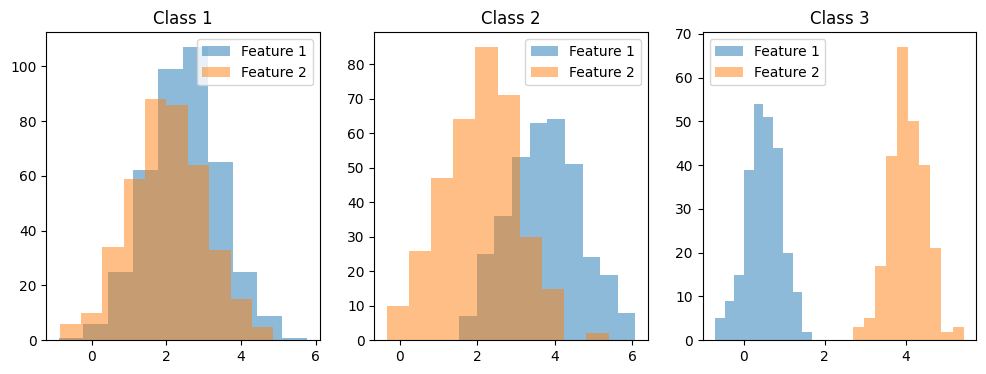

In [150]:
plt.figure(figsize=(12, 4))
for class_label in (0, 1, 2):
    plt.subplot(1, 3, int(class_label + 1))
    plt.hist(df[df['Target'] == class_label]['Feature 1'], alpha=0.5, label='Feature 1')
    plt.hist(df[df['Target'] == class_label]['Feature 2'], alpha=0.5, label='Feature 2')
    plt.title(f'Class {int(class_label + 1)}')
    plt.legend()
plt.show()

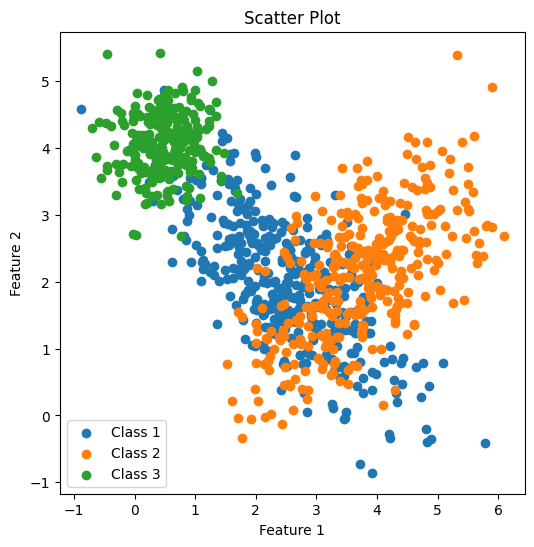

In [151]:
plt.figure(figsize=(6, 6))
for class_label in (0, 1, 2):
    plt.scatter(df[df['Target'] == class_label]['Feature 1'], df[df['Target'] == class_label]['Feature 2'], label=f'Class {class_label + 1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot')
plt.legend()
plt.show()

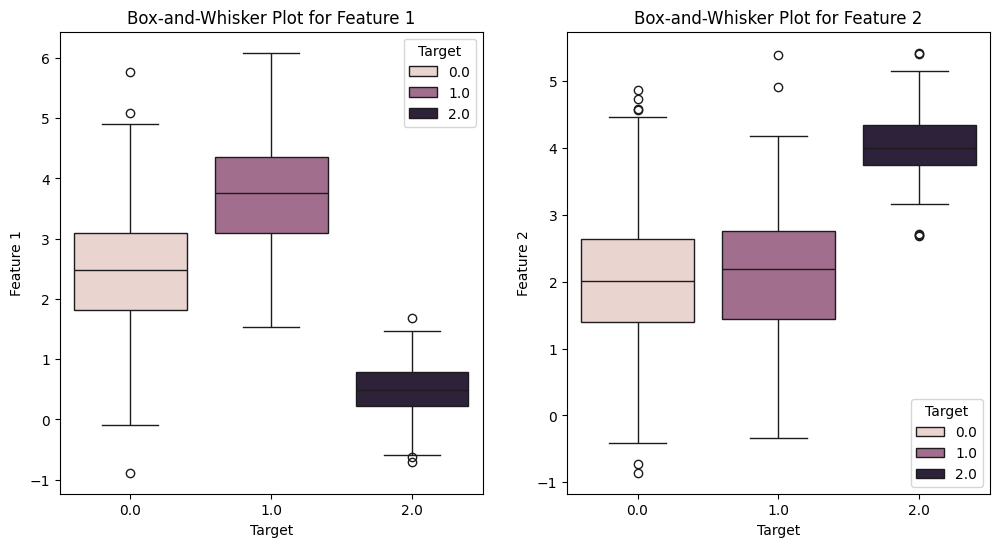

In [152]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(['Feature 1', 'Feature 2']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='Target', y=feature, data=df, hue='Target')
    plt.title(f'Box-and-Whisker Plot for {feature}')
plt.show()

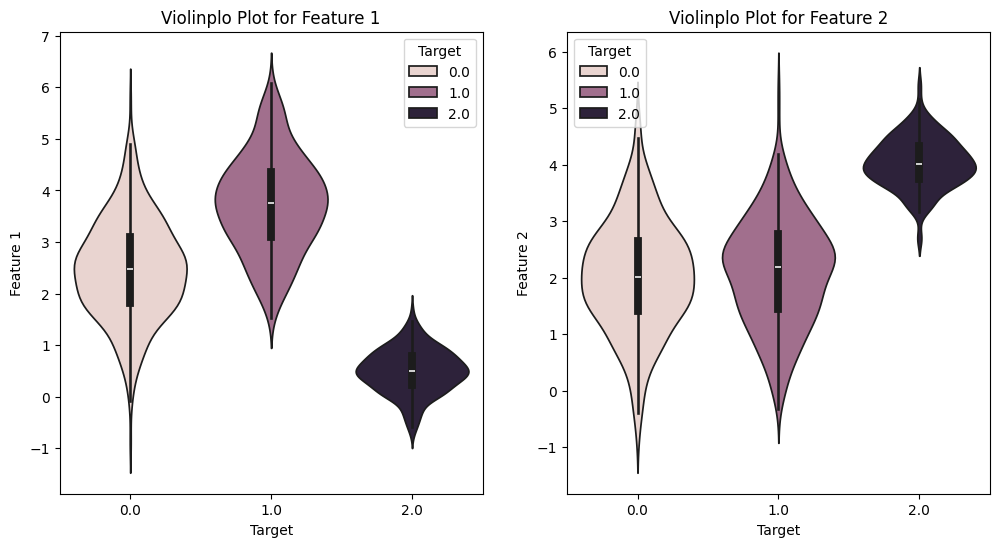

In [153]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(['Feature 1', 'Feature 2']):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='Target', y=feature, data=df, hue='Target')
    plt.title(f'Violinplo Plot for {feature}')
plt.show()

In [154]:
Q1 = df[['Feature 1', 'Feature 2']].quantile(0.25)
Q3 = df[['Feature 1', 'Feature 2']].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[['Feature 1', 'Feature 2']] < (Q1 - 1.5 * IQR)) | (df[['Feature 1', 'Feature 2']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [155]:
df.describe()

,Feature 1,Feature 2,Target
count,1000.000000,1000.000000,1000.000000
mean,2.422782,2.558562,0.850000
std,1.508774,1.222070,0.792545
min,-0.885044,-0.857198,0.000000
25%,1.023004,1.633721,0.000000
50%,2.524125,2.493342,1.000000
75%,3.576468,3.624718,1.250000
max,6.086597,5.428001,2.000000


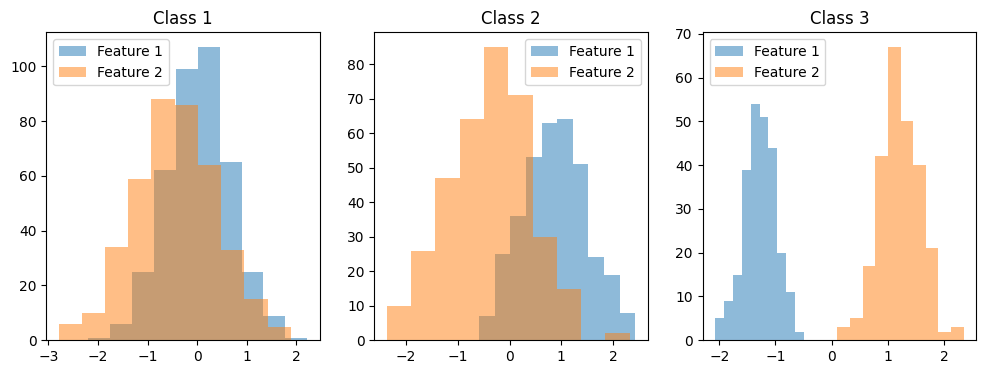

In [156]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Feature 1', 'Feature 2']] = scaler.fit_transform(df[['Feature 1', 'Feature 2']])


plt.figure(figsize=(12, 4))
for class_label in (0, 1, 2):
    plt.subplot(1, 3, int(class_label + 1))
    plt.hist(df[df['Target'] == class_label]['Feature 1'], alpha=0.5, label='Feature 1')
    plt.hist(df[df['Target'] == class_label]['Feature 2'], alpha=0.5, label='Feature 2')
    plt.title(f'Class {int(class_label + 1)}')
    plt.legend()
plt.show()

In [157]:
from sklearn.neighbors import KernelDensity
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Создание обучающей выборки X и меток y (предварительно обработанные данные)
X = np.array(df[['Feature 1', 'Feature 2']])
y = np.array(df['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
bandwidth = np.std(X) * (4/3/len(X)) ** 0.2

kde_models = {}
kernels = ['tophat', 'gaussian', 'epanechnikov', 'exponential']
labels = ['Rectangle', 'Gaussian', 'Epanechnikov', 'Triangular']

for kernel, label in zip(kernels, labels):
    kde_models[label] = {}
    for c in range(3):
        kde_models[label][c] = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X_train[y_train == c])

In [158]:
class KernelDensity_predicter():
    def __init__(self, window):
        self.window = window
    
    def predict_class_array(self, array=None):
        def predict_class_point(window, new_point=None):
            log_likelihoods = [window[kde].score_samples(new_point.reshape(1, -1)) for kde in window]
            return np.argmax(log_likelihoods)
        return np.array([predict_class_point(self.window, new_point = point) for point in array])
        
    def change_bandwidth(self, b):
        for model in self.window:
            self.window[model].bandwidth = b
    
    def relearning(self, X, y):
        for model in self.window:
            self.window[model] = self.window[model].fit(X, y)
            
    def predict_proba(self, array = None):
        def predict_proba_point(window, new_point=None):
            return [window[kde].score_samples(new_point.reshape(1, -1))[0] for kde in window]
        probabilities = np.array([predict_proba_point(self.window, new_point = point) for point in array])
        probabilities[probabilities == -np.inf] = probabilities[probabilities != -np.inf].min()
        probabilities = np.array(list(map(lambda x: np.e**x, probabilities)))
        return probabilities

In [159]:
window_predictors = {name[1]: KernelDensity_predicter({c: KernelDensity(bandwidth=bandwidth, kernel=name[0]).fit(X_train[y_train == c]) for c in range(3)}) for name in zip(kernels, labels)}

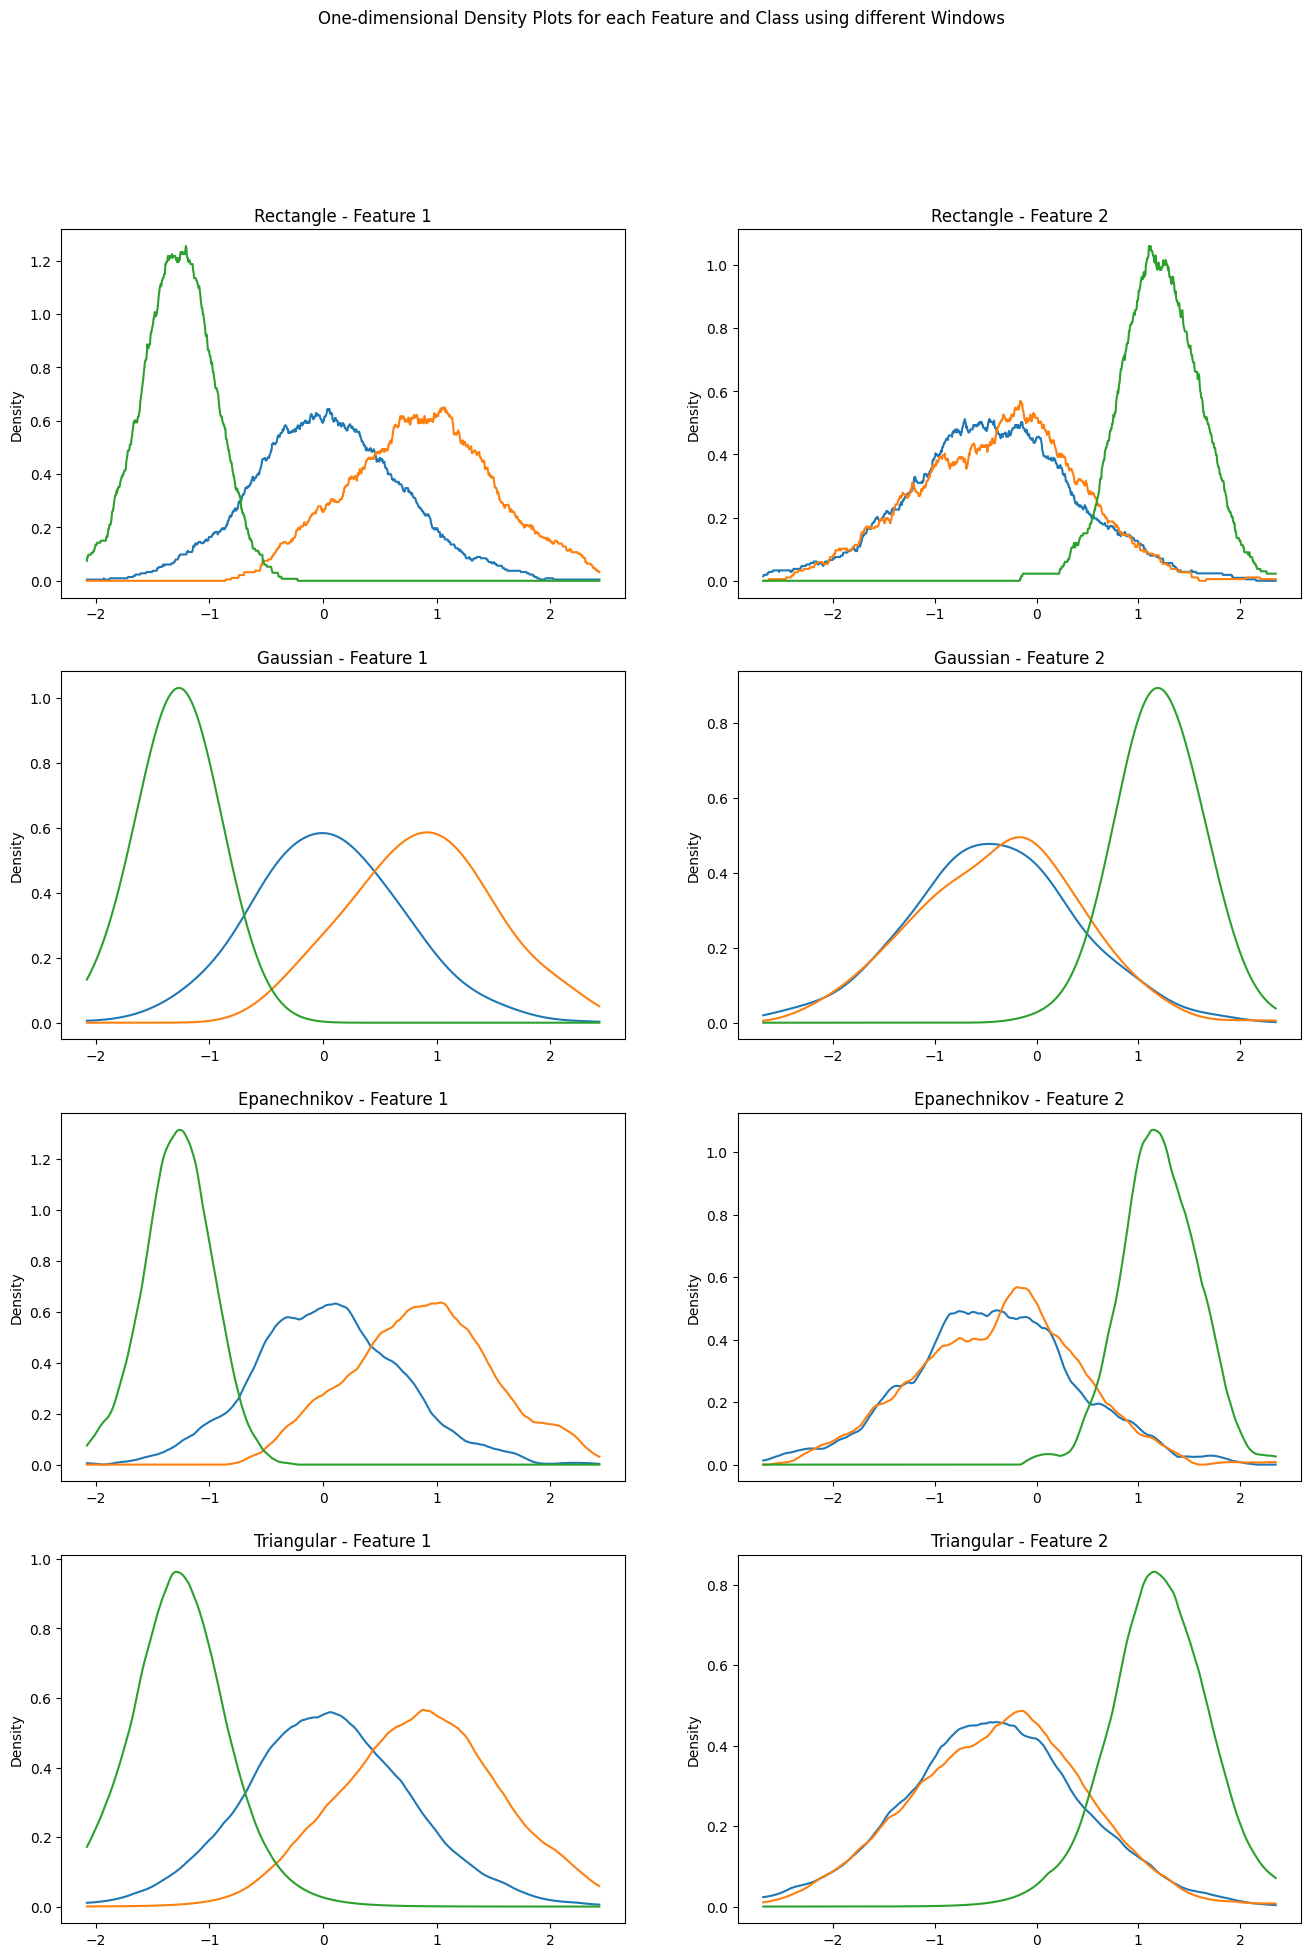

In [160]:
# Построим графики плотностей для каждого класса и каждого признакаc
counter = 0
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 22))
for model in kde_models:
    for i in range(2):  # Цикл по количеству признаков
        for c in range(3):  # Цикл по количеству классов
            kde = kde_models[model][c]
            kde.fit(X[y==c][:, i][:, None])
            x = np.linspace(X_train[:, i].min(), X_train[:, i].max(), 1000)[:, None]
            log_dens = kde.score_samples(x)

            ax[counter, i].plot(x, np.exp(log_dens), label='Class '+str(c))
            ax[counter, i].set_title(f'{model} - Feature {i + 1}')
            ax[counter, i].set_ylabel('Density')

    counter += 1

fig.suptitle('One-dimensional Density Plots for each Feature and Class using different Windows')
plt.show()

In [161]:
from sklearn.metrics import accuracy_score
scores = {}

kfold = KFold(n_splits = 5, shuffle = True, random_state=42)

for label, kernel in zip(labels, kernels):
    accuracy_scores = []
    
    for train, test in kfold.split(X):
        model = KernelDensity_predicter({c: KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(X[train][y[train] == c]) for c in range(3)})
        accuracy_scores.append(accuracy_score(y[test], model.predict_class_array(X[test])))
    scores[label] = {'mean': np.mean(accuracy_scores), 'std': np.std(accuracy_scores)}
    

In [162]:
scores

{'Rectangle': {'mean': 0.779, 'std': 0.030232432915661973},
 'Gaussian': {'mean': 0.8119999999999999, 'std': 0.033256578296631756},
 'Epanechnikov': {'mean': 0.7919999999999999, 'std': 0.03944616584663203},
 'Triangular': {'mean': 0.8039999999999999, 'std': 0.03512833614050057}}

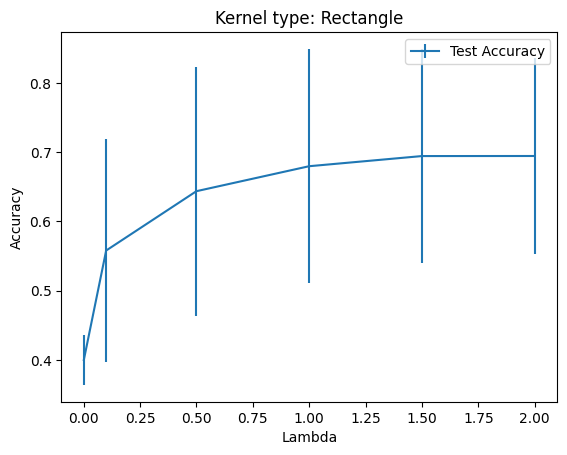

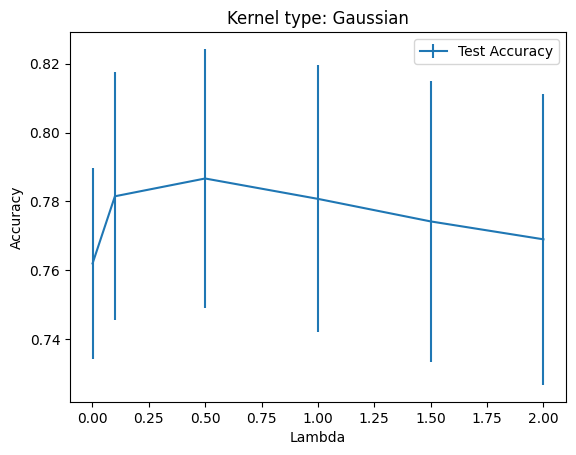

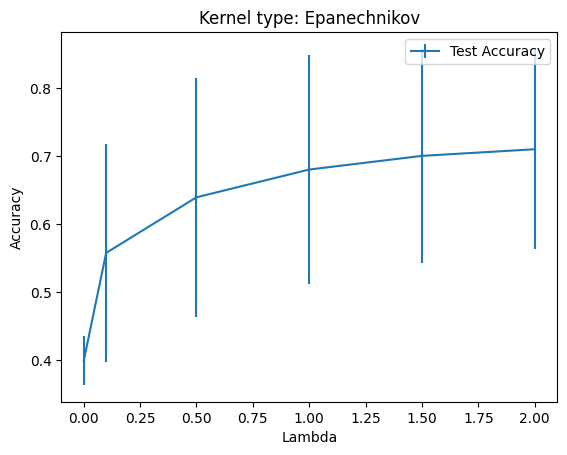

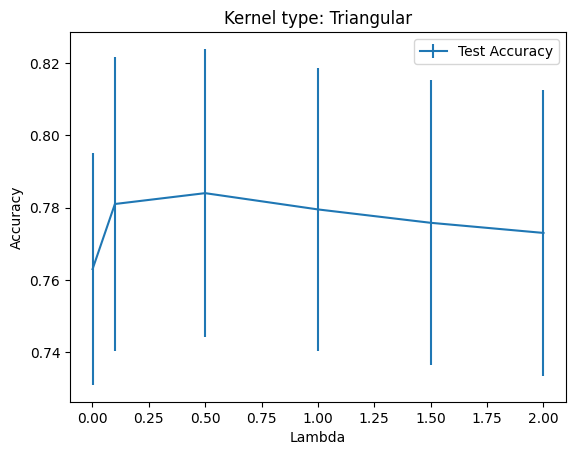

In [328]:
# Для каждого типа окна

for label, kernel in zip(labels, kernels):
    lambdas = [0.001, 0.1, 0.5, 1.0, 1.5, 2.0]
    means, stds = [], []
    accuracy_scores = []
    
    for lambd in lambdas:
        for train, test in kfold.split(X):
            model = KernelDensity_predicter({c: KernelDensity(bandwidth=lambd, kernel=kernel).fit(X[train][y[train] == c]) for c in range(3)})
            accuracy_scores.append(accuracy_score(y[test], model.predict_class_array(X[test])))
        means.append(np.mean(accuracy_scores))
        stds.append(np.std(accuracy_scores))
    
    plt.errorbar(lambdas, means, yerr=stds, label='Test Accuracy')
    plt.xlabel('Lambda')
    plt.ylabel('Accuracy')
    plt.title(f'Kernel type: {label}')
    plt.legend()
    plt.show()

In [164]:
max_mean = 0
best_res = {}
for label, kernel in zip(labels, kernels):
    lambdas = [0.001, 0.1, 0.5, 1.0, 1.5, 2.0]
    means, stds = [], []
    accuracy_scores = []
    
    for lambd in lambdas:
        for train, test in kfold.split(X):
            model = KernelDensity_predicter({c: KernelDensity(bandwidth=lambd, kernel=kernel).fit(X[train][y[train] == c]) for c in range(3)})
            accuracy_scores.append(accuracy_score(y[test], model.predict_class_array(X[test])))
            
        if max_mean < np.mean(accuracy_scores):
            max_mean = np.mean(accuracy_scores)
            best_res['KERNEL TYPE'] = label
            best_res['LAMBDA'] = lambd
            best_res['MEAN'] = max_mean
            best_res['STD'] = np.std(accuracy_scores)
        
        print(f'KERNEL TYPE: {label} | LAMBDA: {lambd} | MEAN: {np.mean(accuracy_scores)} | STD: {np.std(accuracy_scores)}')
        

KERNEL TYPE: Rectangle | LAMBDA: 0.001 | MEAN: 0.4 | STD: 0.03605551275463988
KERNEL TYPE: Rectangle | LAMBDA: 0.1 | MEAN: 0.5579999999999999 | STD: 0.16040885262353818
KERNEL TYPE: Rectangle | LAMBDA: 0.5 | MEAN: 0.6436666666666666 | STD: 0.17955005492124532
KERNEL TYPE: Rectangle | LAMBDA: 1.0 | MEAN: 0.6797499999999999 | STD: 0.16878592210252605
KERNEL TYPE: Rectangle | LAMBDA: 1.5 | MEAN: 0.6944 | STD: 0.15470824153871052
KERNEL TYPE: Rectangle | LAMBDA: 2.0 | MEAN: 0.6945 | STD: 0.14203491354827752
KERNEL TYPE: Gaussian | LAMBDA: 0.001 | MEAN: 0.7619999999999999 | STD: 0.02767670500619612
KERNEL TYPE: Gaussian | LAMBDA: 0.1 | MEAN: 0.7815000000000001 | STD: 0.035989581825856216
KERNEL TYPE: Gaussian | LAMBDA: 0.5 | MEAN: 0.7866666666666666 | STD: 0.03762386949205989
KERNEL TYPE: Gaussian | LAMBDA: 1.0 | MEAN: 0.78075 | STD: 0.03873870803214789
KERNEL TYPE: Gaussian | LAMBDA: 1.5 | MEAN: 0.7742 | STD: 0.0409067231638028
KERNEL TYPE: Gaussian | LAMBDA: 2.0 | MEAN: 0.7690000000000001

In [165]:
best_res

{'KERNEL TYPE': 'Gaussian',
 'LAMBDA': 0.5,
 'MEAN': 0.7866666666666666,
 'STD': 0.03762386949205989}

In [166]:
# Построение диаграмм

x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

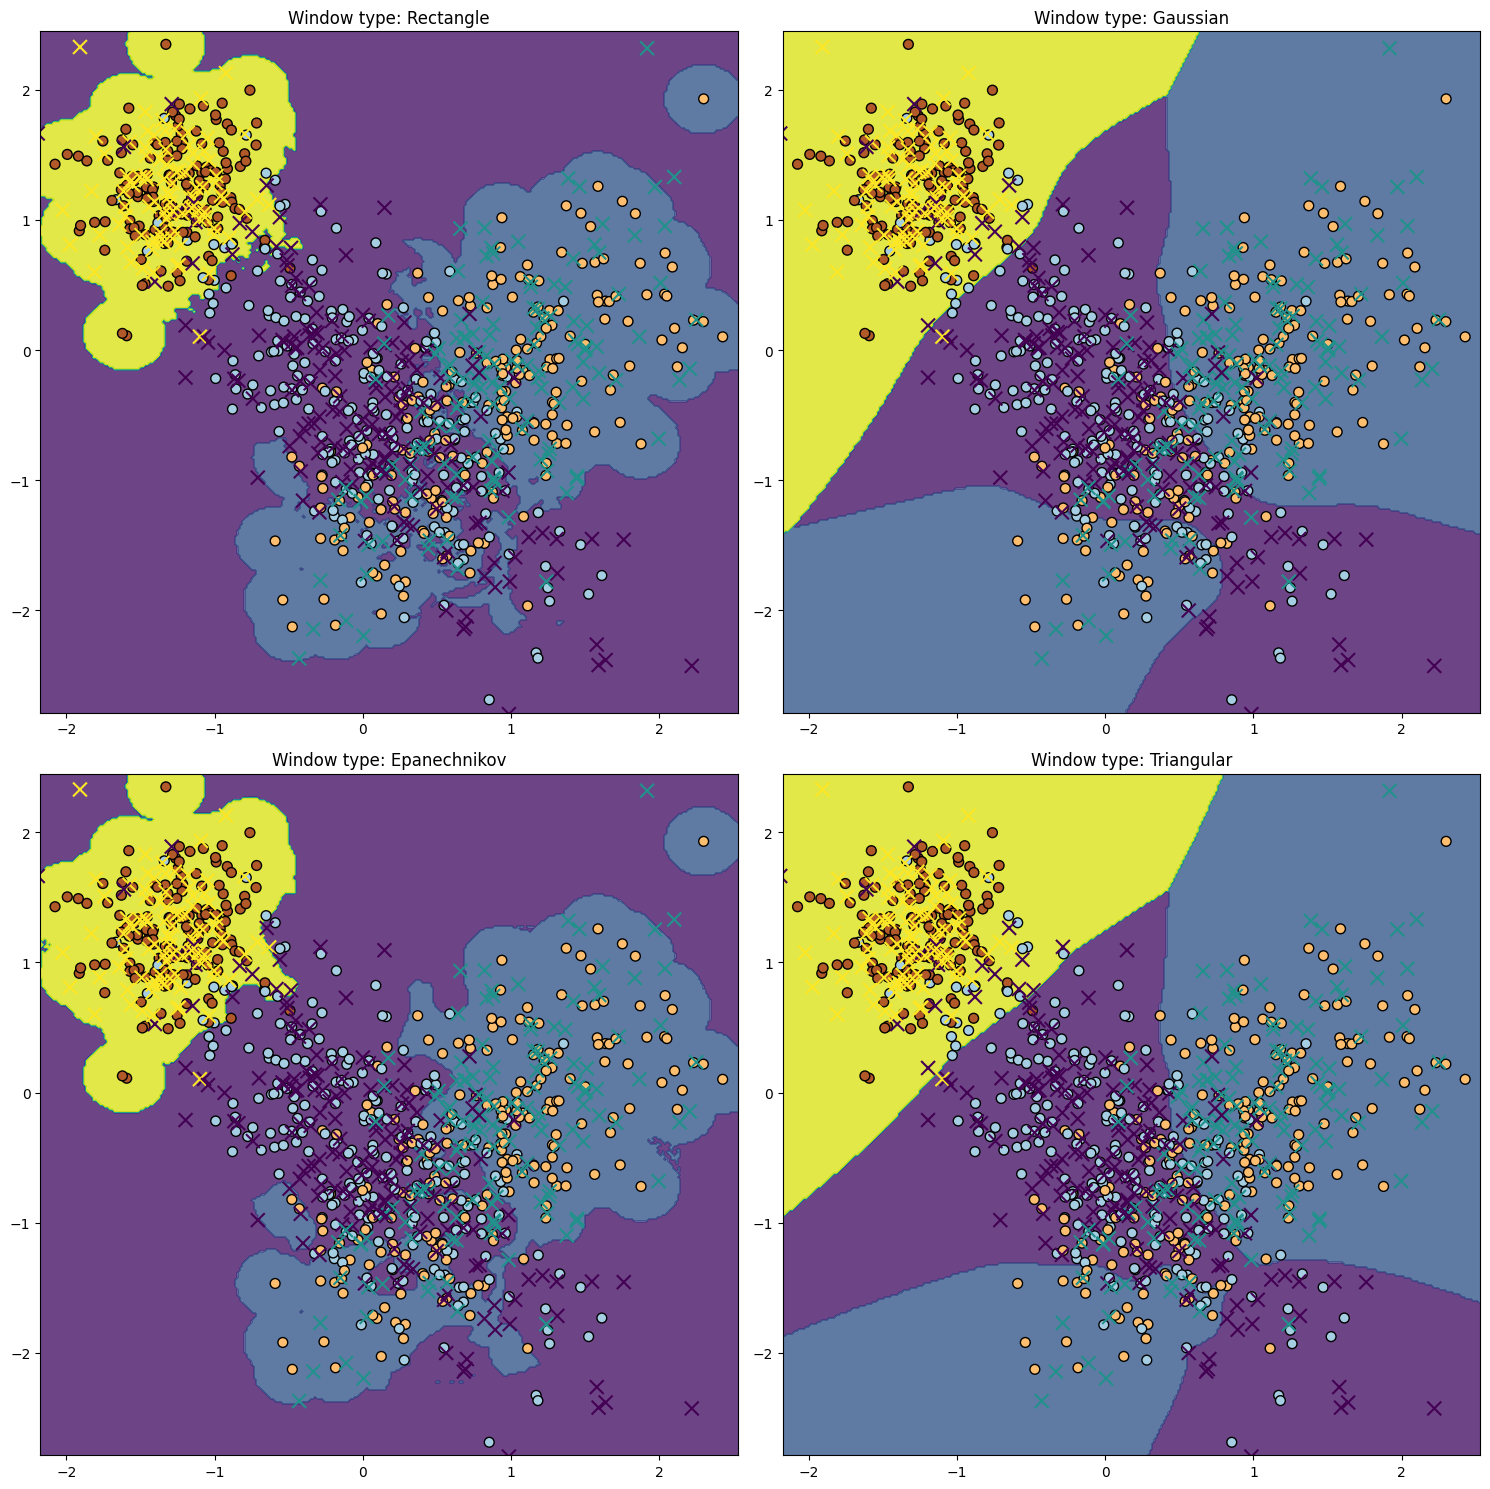

In [167]:
plt.figure(figsize=(15, 15))

for i, label in enumerate(labels, 1):
    plt.subplot(2, 2, i)
    Z = np.exp(window_predictors[label].predict_class_array(np.c_[np.ravel(xx), np.ravel(yy)]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', s=50, cmap=plt.cm.Paired)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=100)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f'Window type: {label}')

plt.tight_layout()
plt.show()


In [273]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [323]:
def custom_pr_curve(y_true, y_pred):
    order = np.argsort(y_pred)[::-1]
    y_true = y_true[order]

    tp = np.cumsum(y_true == 1)
    fp = np.cumsum(y_true == 0)

    precision = tp / (tp + fp)
    recall = tp / tp[-1]

    return precision, recall

def calculate_pr_curves(preds, true_labels):
    n_classes = true_labels.shape[1]
    precisions = []
    recalls = []

    for i in range(n_classes):
        precision = []
        recall = []
        
        for threshold in np.linspace(0, 1, 100):
            pred_labels = np.where(preds[:, i] >= threshold, 1, 0)
            
            true_positives = np.sum(np.logical_and(pred_labels == 1, true_labels[:, i] == 1))
            false_positives = np.sum(np.logical_and(pred_labels == 1, true_labels[:, i] == 0))
            false_negatives = np.sum(np.logical_and(pred_labels == 0, true_labels[:, i] == 1))
            
            if true_positives + false_positives == 0:
                precision.append(0)
            else:
                precision.append(true_positives / (true_positives + false_positives))
                
            if true_positives + false_negatives == 0:
                recall.append(0)
            else:
                recall.append(true_positives / (true_positives + false_negatives))
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Макро-усредненная PR-кривая
    precision_macro = np.mean(np.array(precisions), axis=0)
    recall_macro = np.mean(np.array(recalls), axis=0)
    return precision_macro, recall_macro

In [324]:
def plot_PRcurve(y_onehot_test, y_score, kernel):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(3):
        precision[i], recall[i] = custom_pr_curve(y_onehot_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

    # Расчет micro-averaged precision и recall
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_onehot_test.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

    # Расчет macro-averaged precision и recall
    precision["macro"], recall["macro"] = calculate_pr_curves(y_score, y_onehot_test)
    # Строим PR-кривые
    macro_roc_auc_ovr = roc_auc_score(
        y_onehot_test,
        y_score,
        multi_class="ovr",
        average="macro",
    )
    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post', color='b', alpha=0.5, label='Micro-average PR curve (AP = {0:0.3f})'
             ''.format(average_precision["micro"]))
    plt.fill_between(recall['micro'], precision['micro'], alpha=0.2, color='b')

    plt.step(recall['macro'], precision['macro'], where='post', color='g', alpha=0.5, label=f'Macro-average PR curve (AP = {macro_roc_auc_ovr:.3f})')
    plt.fill_between(recall["macro"], precision["macro"], alpha=0.2, color='g')

    colors = ['r', 'm', 'c']
    for i, color in zip(range(3), colors):
        plt.step(recall[i], precision[i], color=color, alpha=0.5, where='post',
                 label='PR curve of class {0} (AP = {1:0.3f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve for multi-class classification\nKERNEL TYPE: {kernel}')
    plt.legend()
    plt.show()

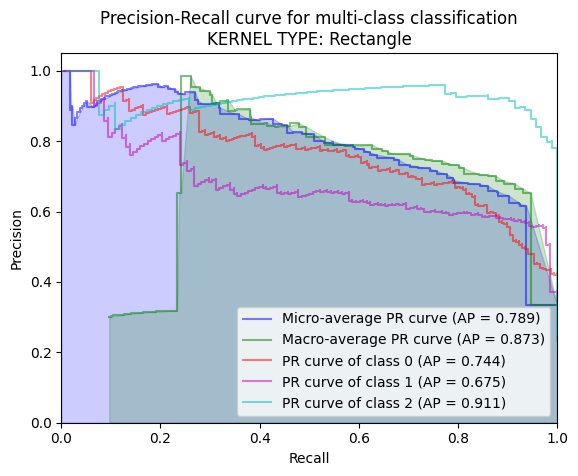

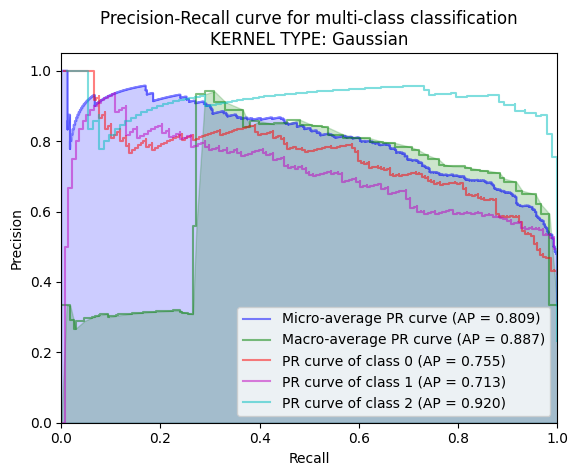

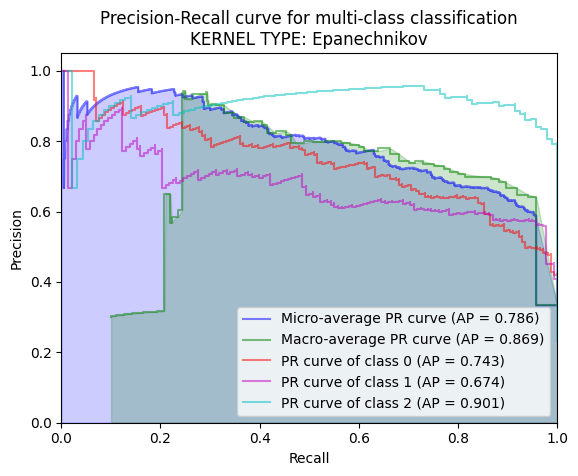

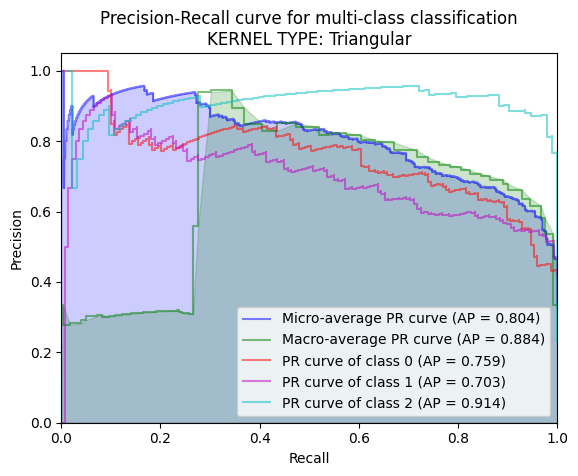

In [325]:
for label in labels:
    y_score = window_predictors[label].predict_proba(X_test)
    plot_PRcurve(y_onehot_test, y_score, label)

In [176]:
from sklearn.metrics import auc, roc_curve
def micro_fpr_tpr(y_onehot_test, y_score, n_classes):
    return roc_curve(y_onehot_test.ravel(), y_score.ravel())

In [177]:
def macro_fpr_tpr(y_onehot_test, y_score, n_classes):
    fpr, tpr = dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    mean_tpr = np.zeros_like(np.linspace(0.0, 1.0, 1000))
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    mean_tpr /= n_classes

    return fpr_grid, mean_tpr

In [179]:
from itertools import cycle

def plot_characteristic(n_classes, y_onehot_test, y_score, micro_fpr, micro_tpr, macro_fpr, macro_tpr, name_label = None):
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        micro_fpr,
        micro_tpr,
        label=f"micro-average ROC curve (AUC = {auc(micro_fpr, micro_tpr):.3f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        macro_fpr,
        macro_tpr,
        label = f"macro-average ROC curve (AUC = {auc(macro_fpr, macro_tpr):.3f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id + 1}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass | kernel type: {label}",
    )

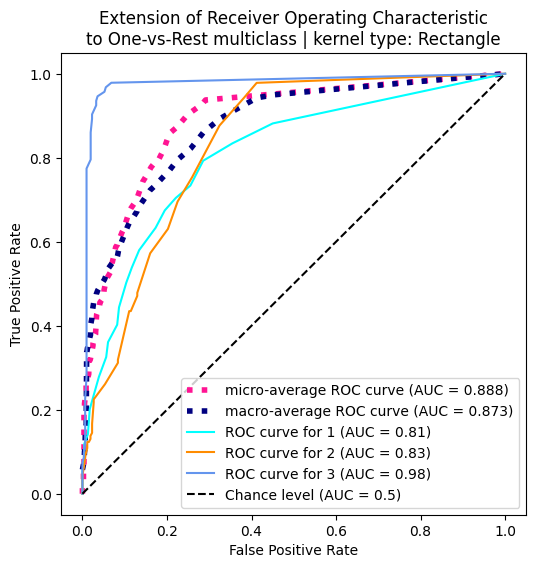

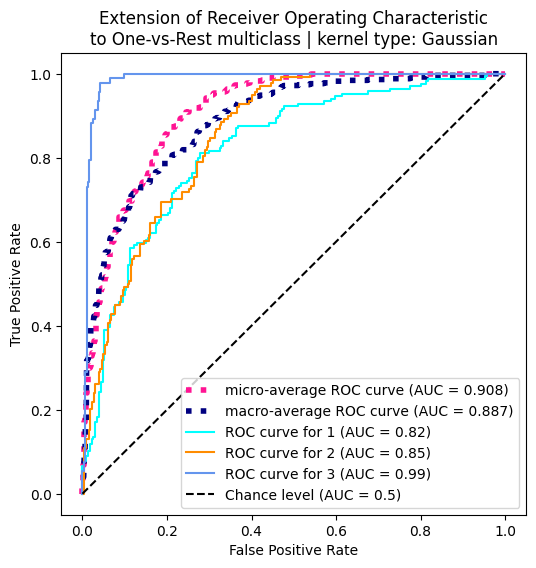

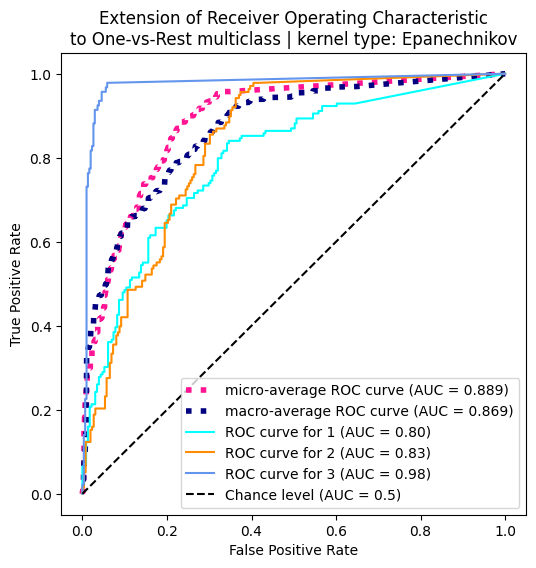

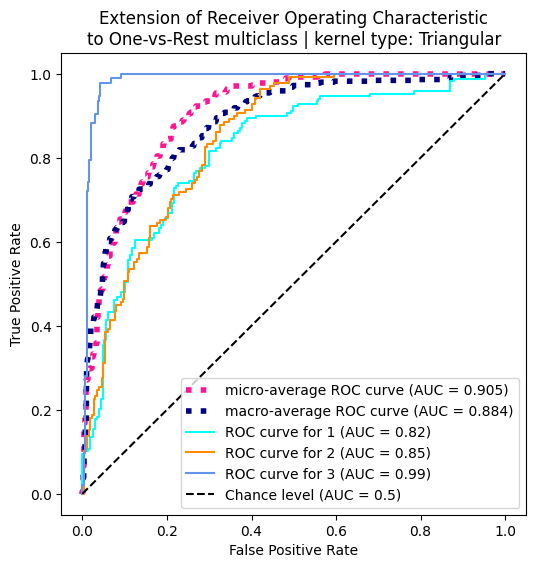

In [314]:
for label in labels:
    y_score = window_predictors[label].predict_proba(X_test)
    micro_macro_d[label]['micro']['fpr'], micro_macro_d[label]['micro']['tpr'], _ = micro_fpr_tpr(y_onehot_test, y_score, 3)
    micro_macro_d[label]['macro']['fpr'], micro_macro_d[label]['macro']['tpr'] = macro_fpr_tpr(y_onehot_test, y_score, 3)
    
    micro_fpr, micro_tpr = micro_macro_d[label]['micro']['fpr'], micro_macro_d[label]['micro']['tpr']
    macro_fpr, macro_tpr = micro_macro_d[label]['macro']['fpr'], micro_macro_d[label]['macro']['tpr']
    
    plot_characteristic(3, y_onehot_test, y_score, micro_fpr, micro_tpr, macro_fpr, macro_tpr, label)

In [319]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

clf = GaussianNB()
clf.fit(X_train, y_train)

# Получаем предсказания на тестовой выборке
y_pred = clf.predict(X_test)

# Рассчитываем accuracy
accuracy = accuracy_score(y_test, y_pred)

# Выполняем кросс-валидацию
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

print(f'Accuracy на тестовой выборке: {accuracy}')
print(f'Среднее значение точности (accuracy) по фолдам: {scores.mean()}')
print(f'Стандартное отклонение точности (accuracy) по фолдам: {scores.std()}')

Accuracy на тестовой выборке: 0.7925
Среднее значение точности (accuracy) по фолдам: 0.7616666666666667
Стандартное отклонение точности (accuracy) по фолдам: 0.030092450142113


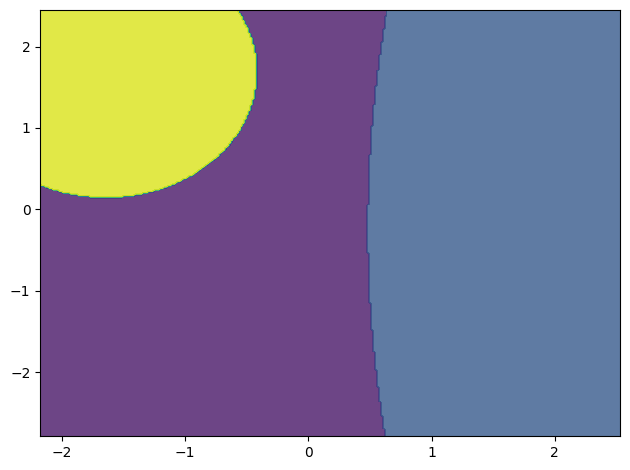

In [326]:
Z = np.exp(clf.predict(np.c_[np.ravel(xx), np.ravel(yy)]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [321]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression().fit(X_train, y_train)
accuracy = accuracy_score(y_test, lg.predict(X_test))
cr = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

print(f'Accuracy на тестовой выборке: {accuracy}')
print(f'Среднее значение точности (accuracy) по фолдам: {cr.mean()}')
print(f'Стандартное отклонение точности (accuracy) по фолдам: {cr.std()}')

Accuracy на тестовой выборке: 0.79
Среднее значение точности (accuracy) по фолдам: 0.7649999999999999
Стандартное отклонение точности (accuracy) по фолдам: 0.026034165586355535


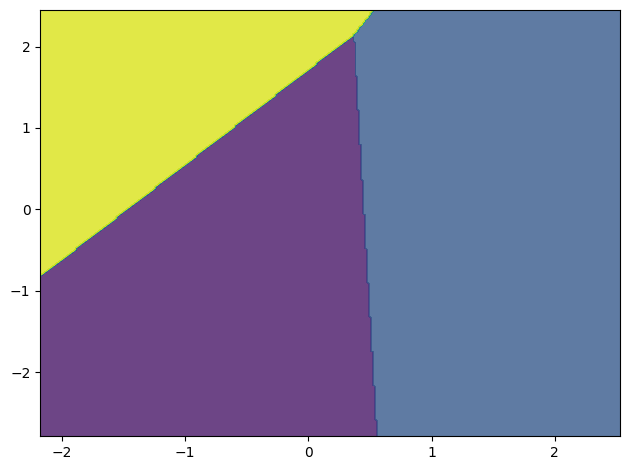

In [327]:
Z = np.exp(lg.predict(np.c_[np.ravel(xx), np.ravel(yy)]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()